In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import sys
from matplotlib.colors import to_rgba
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/Users/glover.co/Documents/laszlo/NetDesign')
import network_design as nd
import netrd
import matplotlib.pyplot as plt
import pynauty as pn

In [3]:
# Read in dataset
df = pd.read_csv('../../data/protein_complex/corum_hint_combined.txt',index_col=False)

In [17]:
def nx_to_pn(G):
    g = pn.Graph(G.number_of_nodes())
    name_to_ix = {name:i for i,name in enumerate(G.nodes())}
    adjacency_dict = {name_to_ix[name]: [name_to_ix[j] for j in G.neighbors(name)] for name in G.nodes()}
    g.set_adjacency_dict(adjacency_dict)
    autogrp = pn.autgrp(g)
    return autogrp[-1]

In [4]:
def logbin(x,y,bins=10):
    """
    Log bin values of y based on x.
    """
    kmin = np.min(x)
    kmax = np.max(x)
    C = (kmax/kmin)**(1/bins)
    binned_x = np.zeros(bins)
    binned_y = np.zeros(bins)
    for b in range(bins):
        # Get cur bin max
        bin_max = C**(b+1)*kmin
        bin_min = C**(b)*kmin
        cur_x = x[x<bin_max]
        cur_y = y[x<bin_max]
        cur_y = cur_y[cur_x>=bin_min]
        cur_x = cur_x[cur_x>=bin_min]
        binned_x[b] = np.mean(cur_x)
        binned_y[b] = np.mean(cur_y)
    return binned_x, binned_y

In [5]:
# Make networks
complex_ids = pd.unique(df['complex_id'])

In [6]:
len(complex_ids)

1910

In [7]:
distinct_complexes = {}

In [8]:
for i in complex_ids:
    # Get rows
    cur_id = df[df.complex_id == i]
    g = nx.Graph()
    for index, row in cur_id.iterrows():
        g.add_edge(row['Uniprot_A'],row['Uniprot_B'])
    if g.number_of_nodes() == 0:
        continue
    distinct_complexes[i] = g

In [28]:
# Dataset statistics
number_of_complexes = len(distinct_complexes.keys())
size_of_complexes = np.zeros(number_of_complexes)
avg_k = np.zeros(number_of_complexes)
cc = np.zeros(number_of_complexes)
cycle_basis = np.zeros(number_of_complexes)
orbits = np.zeros(number_of_complexes)
cycle_basis_norm = np.zeros(number_of_complexes)
orbits_norm = np.zeros(number_of_complexes)
second_moments = np.zeros(number_of_complexes)
coeff_of_variation = np.zeros(number_of_complexes)

In [41]:
for idx, i in enumerate(distinct_complexes.keys()):
    # Get network
    g = distinct_complexes[i]
    size_of_complexes[idx] = g.number_of_nodes()
    avg_k[idx] = 2*g.number_of_edges()/g.number_of_nodes()
    cc[idx] = nx.average_clustering(g)
    cycle_basis[idx] = g.number_of_edges() - g.number_of_nodes() + len(list(nx.connected_components(g)))
    orbits[idx] = nx_to_pn(g)
    cycle_basis_norm[idx] = (g.number_of_edges() - g.number_of_nodes() + len(list(nx.connected_components(g))))/g.number_of_edges()
    orbits_norm[idx] = nx_to_pn(g)/g.number_of_nodes()
    second_moments[idx] = np.mean([k**2 for k in np.array(nx.convert_node_labels_to_integers(g).degree())[:,1]])
    coeff_of_variation[idx] = np.std(np.array(nx.convert_node_labels_to_integers(g).degree())[:,1])/avg_k[idx]

In [36]:
count = 0
for i in complex_ids:
    try:
        if distinct_complexes[i].number_of_nodes() > 2:
            count += 1
    except:
        continue
count

905

In [37]:
len(count_x), len(count_y)

(12, 12)

/Users/glover.co/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/glover.co/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


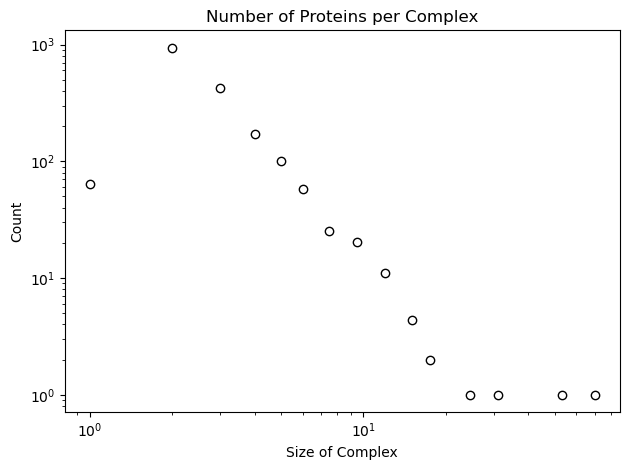

In [13]:
count_x, count_y = np.unique(size_of_complexes,return_counts=True)
x, y = logbin(count_x,count_y,bins=20)
fig, ax = plt.subplots()
ax.scatter(x,y,color='w',edgecolors='k')
ax.set_xlabel('Size of Complex')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Count')
plt.title('Number of Proteins per Complex')
plt.tight_layout()
plt.savefig('figs/size.pdf')
plt.show()

/Users/glover.co/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/glover.co/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


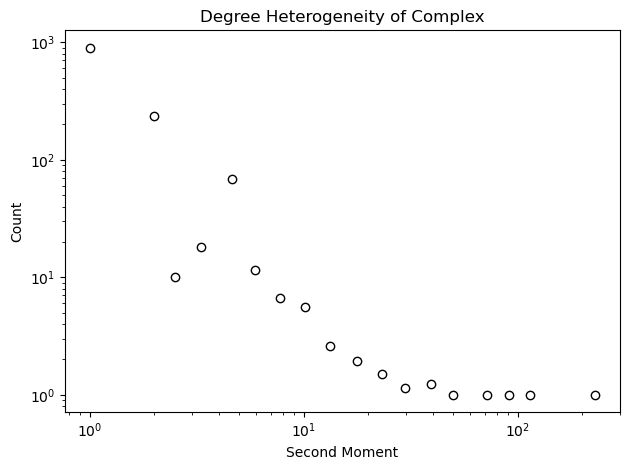

In [38]:
count_x, count_y = np.unique(second_moments,return_counts=True)
x, y = logbin(count_x,count_y,bins=20)
fig, ax = plt.subplots()
ax.scatter(x,y,color='w',edgecolors='k')
ax.set_xlabel('Second Moment')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Count')
plt.title('Degree Heterogeneity of Complex')
plt.tight_layout()
plt.savefig('figs/deg_hetero.pdf')
plt.show()

In [45]:
# count_x, count_y = np.unique(coeff_of_variation,return_counts=True)
# x, y = logbin(count_x,count_y,bins=20)
# fig, ax = plt.subplots()
# ax.scatter(x,y,color='w',edgecolors='k')
# ax.set_xlabel(r'$\langle k^2\rangle/\langle k\rangle$')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylabel('Count')
# plt.title('Coeff. of Variation of Complex')
# plt.tight_layout()
# plt.savefig('figs/coeff_of_variation.pdf')
# plt.show()

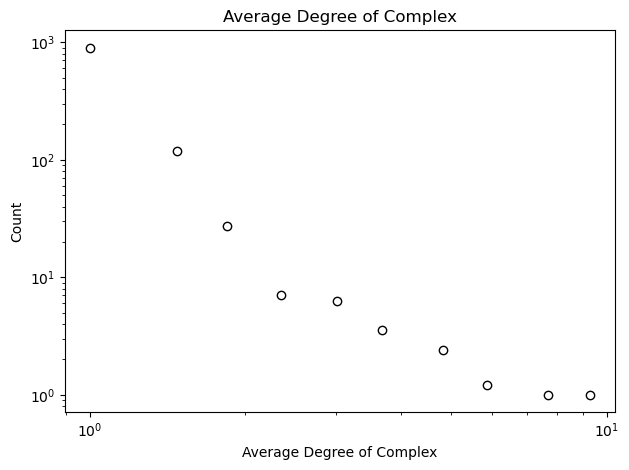

In [14]:
count_x, count_y = np.unique(avg_k,return_counts=True)
x, y = logbin(count_x,count_y,bins=10)
fig, ax = plt.subplots()
ax.scatter(x,y,color='w',edgecolors='k')
ax.set_xlabel('Average Degree of Complex')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Count')
plt.title('Average Degree of Complex')
plt.tight_layout()
plt.savefig('figs/avg_k.pdf')
# plt.loglog(x[:-1],1000*x[:-1]**(-3),'--')
plt.show()

In [15]:
# count_x[0] += .01
logbin(count_x, count_y,bins=10)

(array([1.        , 1.47777778, 1.84271247, 2.34575116, 3.01425937,
        3.66920857, 4.82767446, 5.8585453 , 7.69444444, 9.27272727]),
 array([899.        , 119.        ,  27.33333333,   7.        ,
          6.33333333,   3.5625    ,   2.38461538,   1.22222222,
          1.        ,   1.        ]))

/Users/glover.co/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/glover.co/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


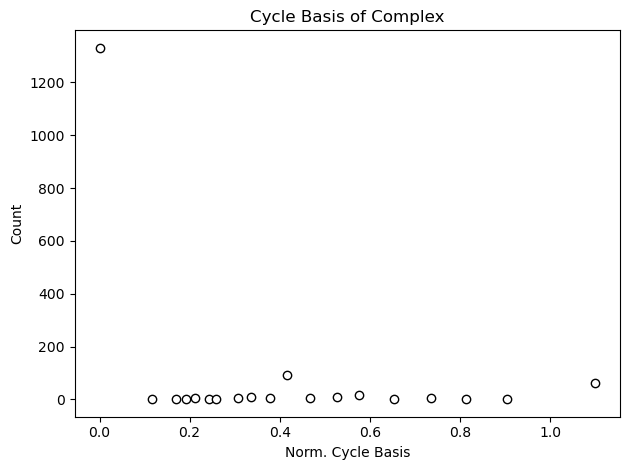

In [76]:
count_x, count_y = np.unique(cycle_basis_norm,return_counts=True)
count_x += .1
x, y = logbin(count_x[1:],count_y[1:],bins=20)
# y,x = np.histogram(cycle_basis,bins=20)
# x = x[:-1]
fig, ax = plt.subplots()
ax.scatter(x,y,color='w',edgecolors='k')
ax.scatter(0,count_y[0],color='w',edgecolors='k')
ax.set_xlabel('Norm. Cycle Basis')
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count')
plt.title('Cycle Basis of Complex')
plt.tight_layout()
plt.savefig('figs/cycle_basis_lin_norm.pdf')
# plt.loglog(x[:-1],1000*x[:-1]**(-3),'--')
plt.show()

/Users/glover.co/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/glover.co/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


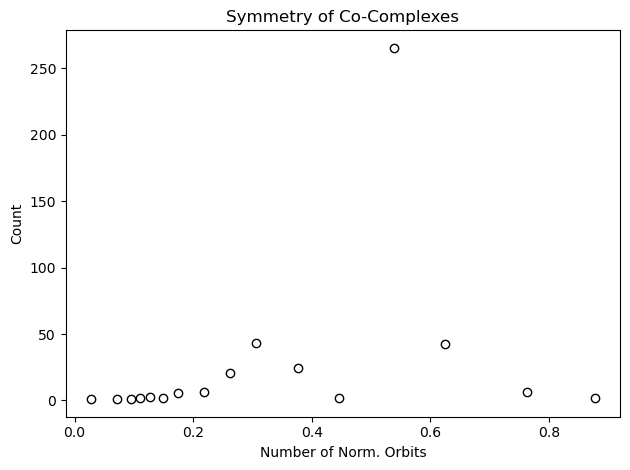

: 

In [77]:
count_x, count_y = np.unique(orbits_norm,return_counts=True)
# count_x += .1
x, y = logbin(count_x[:],count_y[:],bins=20)
# y,x = np.histogram(cycle_basis,bins=20)
# x = x[:-1]
fig, ax = plt.subplots()
ax.scatter(x,y,color='w',edgecolors='k')
# ax.scatter(0,count_y[0],color='w',edgecolors='k')
ax.set_xlabel('Number of Norm. Orbits')
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count')
plt.title('Symmetry of Co-Complexes')
plt.tight_layout()
plt.savefig('figs/orbits_linear_norm.pdf')
# plt.loglog(x[:-1],1000*x[:-1]**(-3),'--')
plt.show()

# Compare true network with reconstructed network

In [46]:
graphs = {}
for i in complex_ids:
    try:
        graphs[i] = nx.read_edgelist(f'../../data/protein_complex/graphs/g_{i}.txt')
    except:
        continue

In [47]:
reconstructed_graphs_01 = {}
for i in complex_ids:
    try:
        reconstructed_graphs_01[i] = nx.read_edgelist(f'../../data/protein_complex/reconstructed_graphs/01_g_{i}.txt')
    except:
        continue

In [48]:
reconstructed_graphs_1 = {}
for i in complex_ids:
    try:
        reconstructed_graphs_1[i] = nx.read_edgelist(f'../../data/protein_complex/reconstructed_graphs/1_g_{i}.txt')
    except:
        continue

In [51]:
connected_components_01 = np.zeros(len(complex_ids))
connected_components_1 = np.zeros(len(complex_ids))
counter = 0
node_count = np.zeros(len(complex_ids))
graphs_large = []
for idx, i in enumerate(complex_ids):
    try:
        g = graphs[i]
        if g.number_of_nodes() <= 2:
            continue
        recon_01 = reconstructed_graphs_01[i]
        recon_1 = reconstructed_graphs_1[i]
        connected_components = list(nx.connected_components(recon_01))
        for c in connected_components:
            if nx.is_isomorphic(nx.subgraph(recon_01,c),g):
                connected_components_01[counter] += 1
        connected_components = list(nx.connected_components(recon_1))
        for c in connected_components:
            if nx.is_isomorphic(nx.subgraph(recon_1,c),g):
                connected_components_1[counter] += 1
        node_count[counter] = nx_to_pn(g)
        counter+=1
        graphs_large.append(i)
    except:
        continue
con_comp_01_large = connected_components_01[:counter]
con_comp_1_large = connected_components_1[:counter]

/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_31659/3747507639.py:3: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,11**3)


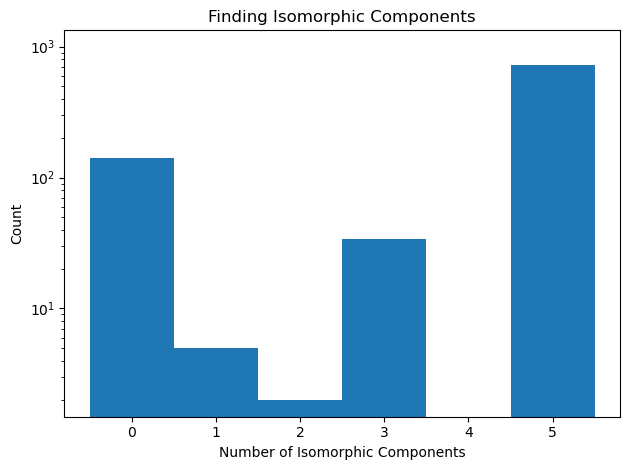

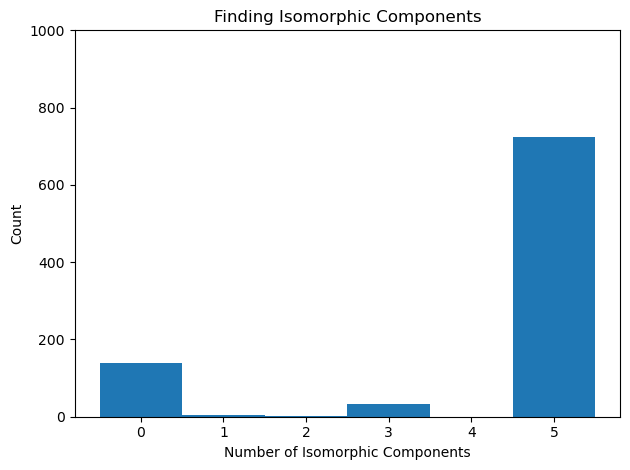

In [61]:
plt.hist(connected_components_1[:counter],bins=np.arange(7)-.5)
plt.yscale('log')
plt.ylim(0,11**3)
plt.xticks([0,1,2,3,4,5],[0,1,2,3,4,5])
plt.xlabel('Number of Isomorphic Components')
plt.ylabel('Count')
plt.title('Finding Isomorphic Components')
plt.tight_layout()
plt.savefig('figs/isomorphic_count_log.pdf')
plt.show()
plt.hist(connected_components_1[:counter],bins=np.arange(7)-.5)
plt.yscale('linear')
plt.ylim(0,10**3)
plt.xticks([0,1,2,3,4,5],[0,1,2,3,4,5])
plt.xlabel('Number of Isomorphic Components')
plt.ylabel('Count')
plt.title('Finding Isomorphic Components')
plt.tight_layout()
plt.savefig('figs/isomorphic_count_linear.pdf')
plt.show()

In [73]:
g = graphs[graphs_large[2]]
X = np.eye(g.number_of_nodes())
O = nx.adjacency_matrix(g).toarray()
pro_ex_1 = nd.NetAssembly(new_X,O,new_X.sum(axis=0,dtype=int))
pro_ex_1.g = reconstructed_graphs_01[graphs_large[2]]
pro_ex_1.draw(with_networkx=False,output='figs/protein_run.pdf')

<Figure size 500x500 with 0 Axes>

In [65]:
g = graphs[graphs_large[2]]
X = np.eye(g.number_of_nodes())
O = nx.adjacency_matrix(g).toarray()
new_X = np.tile(X,reps=(5,1))
pro_ex_1 = nd.NetAssembly(new_X,O,new_X.sum(axis=0,dtype=int))
# pro_ex_1.g = g
pro_ex_1.draw(with_networkx=False,output='figs/protein_ex1_soup.pdf')

<Figure size 500x500 with 0 Axes>

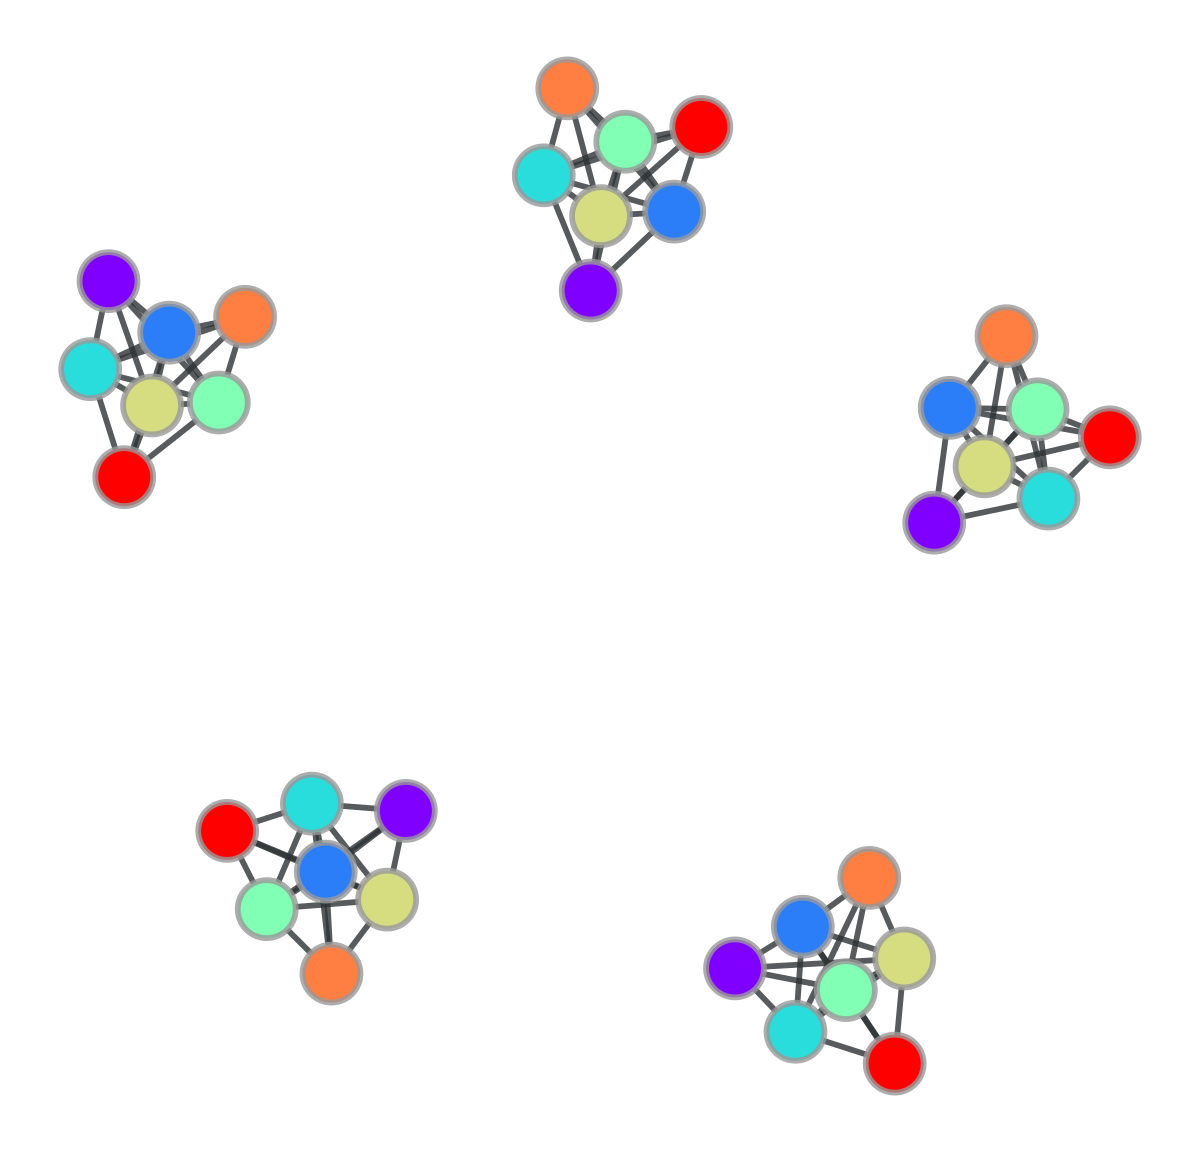

<Figure size 500x500 with 0 Axes>

In [68]:
g = graphs[graphs_large[2]]
X = np.eye(g.number_of_nodes())
O = nx.adjacency_matrix(g).toarray()
new_X = np.tile(X,reps=(5,1))
pro_ex_1 = nd.NetAssembly(new_X,O,new_X.sum(axis=0,dtype=int))
pro_ex_1.run(10000)
# pro_ex_1.g = g


In [69]:
pro_ex_1.draw(with_networkx=False,output='figs/protein_ex1_5_comp.pdf')

<Figure size 500x500 with 0 Axes>

In [44]:
recon_1 = reconstructed_graphs_1[graphs_large[2]]
recon_01 = reconstructed_graphs_01[graphs_large[2]]

In [48]:
connected_components = list(nx.connected_components(recon_1))
for c in connected_components:
    if nx.is_isomorphic(nx.subgraph(recon_1,c),g):
        print('here')

here
here
here
here
here


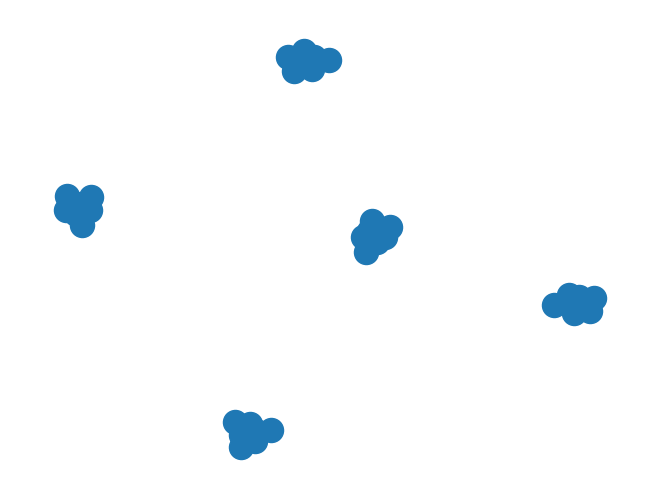

In [51]:
nx.draw(recon_1)

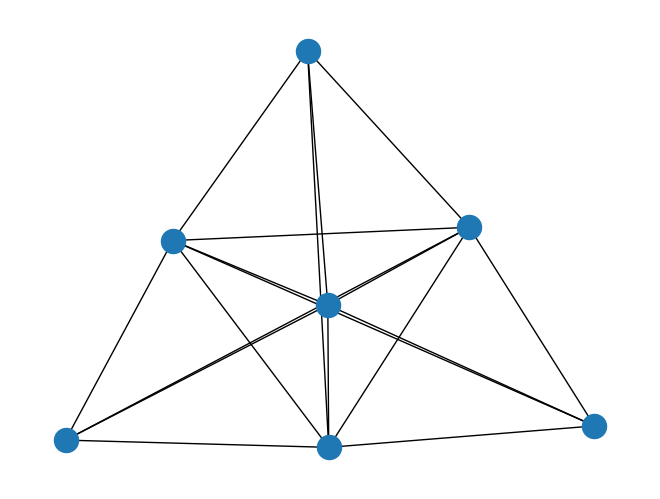

In [52]:
nx.draw(g)

In [30]:
con_comp_01_large[2]

0.0